H I 😀

>This script is provided for **task 1** & **task 2** and **tile and Augmentation Preprocessing**.
>This script is privately provided by Mohamad NAJAFI for the DiaDeep PhD applicant task. The task consists of three parts, and all the necessary scripts have been provided to achieve the requested results.
The description of task is provided as [Segmentation: WSI and U-Net Pipeline Manipulation](https://informationsharing.notion.siteSegmentation-WSI-and-U-Net-Pipeline-Manipulation-82a91afd8c24478f8be89c61bd04ba85).

> It should be mentioned that the main chalenges and important points are as follows for me:

- The 'annotation.csv' file cannot be read as a dataframe because all the data is stored in the first column of the CSV file. Additionally, there is an issue with reading the LINESTRING format of the geometry data. This requires parsing the data to obtain WKT or OPENCV geometry data, which needs to be addressed.
- I have expriences in tensorflow and leras for DML and DL application, however, I tried to not use tf libraries and just work with **torch** in this project.


> I am available and open to optimizing this script for various WSI image segmentation purposes. Having gained a better understanding of its functionality, I believe it would be applicable to focus on a specific class of annotation terms or a selected tissue for further refinement. Additionally, to achieve superior results, I've prepared a pilot format for fine-tuning SMP models using predefined weights. This can be applied on an augmented dataset generated by me from tiles of the original image, especially when ample image data is available and can be processed on a robust server.


> I am available to offer explanations or make modifications to this script based on your specific inquiry.

> Mohamad Najafi

In [1]:
# installing libvips in os is different and vips-dev-8.14 should be download and add in path directory environment

# !apt-get install -y libvips
# !pip install pyvips

In [2]:
import os
import pandas as pd
import cv2
from shapely import wkt
from shapely.affinity import scale
import numpy as np
import pyvips
import matplotlib.pyplot as plt
import re
import csv
from skimage import color
from scipy import ndimage as ndi
import torch
from pprint import pprint
from google.colab import drive
from zipfile import ZipFile
from glob import glob
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, CoarseDropout
import random
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
import random

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/TestDiaDeep


/content/drive/MyDrive/TestDiaDeep


In [5]:
# #with ZipFile(os.getcwd()+'/content/drive/MyDrive/TestDiaDeep/new_data_WSI.zip','r') as zObject:
# #    zObject.extractall('/content/drive/MyDrive/TestDiaDeep')

> Parsing the csv data is conducting as Follows to prepare and read the geometry data of anotation.

In [6]:
# Directory containing the .png WSI images
WSIpath = 'm9de8lfp.tif'

# Directory to save the generated segmentation masks
MASK_DIR = 'mask'
os.makedirs(MASK_DIR, exist_ok=True)

# Read the annotations CSV file
csv_file_path = 'annotations.csv'


######################
# Define a function to split a line based on commas inside double quotes
def split_line(line):
    return re.split(r',(?=(?:(?:[^"]*"){2})*[^"]*$)', line)

# Initialize empty lists to store data
filenames = []
annotation_ids = []
annotation_terms = []
areas = []
perimeters = []
wkt_geometries = []
opencv_geometries = []
us_tif_urls = []
eu_tif_urls = []
as_tif_urls = []

# Read the CSV file and split lines based on commas inside double quotes
with open(csv_file_path, 'r') as csv_files:
    csv_reader = csv.reader(csv_files)
    header = next(csv_reader)  # Read the header line
    for row in csv_reader:
        # Split the row using our custom split_line function
        row_data = split_line(','.join(row))

        # Append data to respective lists
        filenames.append(row_data[0])
        annotation_ids.append(row_data[1])
        annotation_terms.append(row_data[2])
        areas.append(row_data[3])
        perimeters.append(row_data[4])
        wkt_geometries.append(row_data[5])
        opencv_geometries.append(row_data[6])
        us_tif_urls.append(row_data[7])
        eu_tif_urls.append(row_data[8])
        as_tif_urls.append(row_data[9])

# Now we have all the information stored in separate lists with correct parsing

# Create a dictionary with column names as keys and lists as values
data = {
    'filename': filenames,
    'Annotation_ID': annotation_ids,
    'Annotation_Term': annotation_terms,
    'Area': areas,
    'Perimeter': perimeters,
    'WKT_geometry': wkt_geometries,
    'opencv_geometry': opencv_geometries,
    'us_tif_url': us_tif_urls,
    'eu_tif_url': eu_tif_urls,
    'as_tif_url': as_tif_urls
}


# Create a DataFrame from the dictionary
annotations = pd.DataFrame(data)
annotations['opencv_geometry'] = annotations['opencv_geometry'].str.replace('"LINESTRING', 'LineString')

> For having all ROIs in different color with respect to their labels, color mapping for different Annotation_Term values for the purpose of multi-class segmentation if needed.

In [7]:
color_mapping = {
    'Dermal component of melanoma': (255, 0, 0), #BLUE
    'Intra-epidermal component of melanoma': (0, 255, 0), #GREEN
    'Normal dermis':(0, 0, 255), #RED
    'Normal sub-cutaneous tissue':(0, 255, 255), #!
    'Normal epidermis (with papillary dermis)':(255, 255, 0)
}

# load the 32x downsampled image from page 4 (2 ** 4 = 32)
slide = pyvips.Image.new_from_file(WSIpath, page=5)
print(slide.width, slide.height)
slide.pngsave('slide_DS32_1.png')

# Convert the image to a NumPy array
buffer = slide.write_to_memory()
image_array = np.frombuffer(buffer, dtype=np.uint8)

# Assuming 'slide' is a 3-band image (RGB), so reshape it
image_array = image_array.reshape(slide.height, slide.width, slide.bands)


# Function to apply geometry change in different resolution
def Apply_geometry(row):
    change_geometry = wkt.loads(row['opencv_geometry'])
    change_geometry = scale(change_geometry, xfact=1/32, yfact=1/32, origin=(0, 0))
    return change_geometry


# In WSI down sample version 'slide_width', 'slide_height' are its dimensions
slide_width, slide_height = slide.width, slide.height


for filename in annotations['filename'].unique():
    # Change the file extension from .tif to .png
    tif_filename = os.path.splitext(filename)[0] + '.tif'

    # Read the corresponding WSI image
    # wsi_image = cv2.imread(WSIpath)
    height, width = slide_width, slide_height

    # Create an empty mask for the WSI image
    mask = np.zeros((width,height, 3), dtype=np.uint8)

    # Extract the annotations for the current WSI image
    image_annotations = annotations[annotations['filename'] == tif_filename]

    # Filter image_annotations based on the desired Annotation_Term values
    image_annotations = image_annotations[image_annotations['Annotation_Term'].isin(['Dermal component of melanoma', 'Intra-epidermal component of melanoma',
                                                                        'Normal dermis', 'Normal sub-cutaneous tissue', 'Normal epidermis (with papillary dermis)'])]


    # Iterate through the annotations and draw LineStrings on the mask
    for index, row in image_annotations.iterrows():
        change_geometry = Apply_geometry(row)

        if change_geometry.geom_type == 'LineString':
            line_points = np.array(change_geometry.coords, dtype=np.float32)
        else:
            print(f"Unsupported geometry type: {change_geometry.geom_type}")
            continue

        # Convert points to integer (uncomment if necessary)
        pts = np.int32(line_points)
        pts = pts.reshape((-1, 1, 2))

        # Draw lines on the mask (uncomment if necessary)
        cv2.polylines(mask, [pts], isClosed=True, color=color_mapping[row['Annotation_Term']])


    # Save the generated mask
    mask_filename = os.path.splitext(filename)[0] + '_MASK_new_32.png'
    cv2.imwrite(os.path.join(MASK_DIR, mask_filename), mask,[cv2.IMWRITE_PNG_COMPRESSION, 0])




2432 2656


> Accessing to ROIs in 32 down sampling version

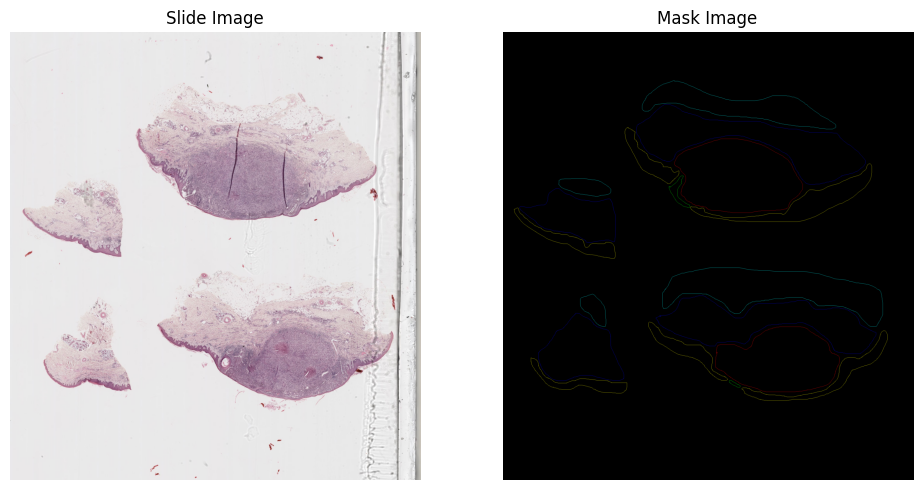

In [8]:
plt.figure(figsize=(10, 5))

# Display slide
plt.subplot(1, 2, 1)
plt.title('Slide Image')
plt.imshow(image_array)
plt.axis('off')

# Display mask
plt.subplot(1, 2, 2)
plt.title('Mask Image')
plt.imshow(mask, cmap='gray')  # Assuming the mask is grayscale
plt.axis('off')

plt.tight_layout()
plt.show()

> Performing image processing to reach the mask as the Ground Truth for segmentation purpose.

In [9]:
# gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
gray_mask = color.rgb2gray(mask)
# Set the threshold to 0
threshold_value = 0

# Apply binary thresholding
binary_mask = (gray_mask > threshold_value).astype(np.uint8) * 255

# Assuming 'binary_image' binary image with values 0 or 255
filled_mask = ndi.binary_fill_holes(binary_mask == 255)

# Convert back to 0 and 255
filled_mask = filled_mask.astype(np.uint8)*255

In [10]:
result = color.rgb2gray(image_array)*filled_mask
result_image_uint8 = result.astype(np.uint8) * 255

> Applying morpholoical operation to reach a consistence image to use it for train and also selecting each tissue that is purposed for further processing.

In [11]:
radius = 9

# Create a circular kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))

# Perform closing operation
closed_image = cv2.morphologyEx(filled_mask, cv2.MORPH_CLOSE, kernel,iterations=4)


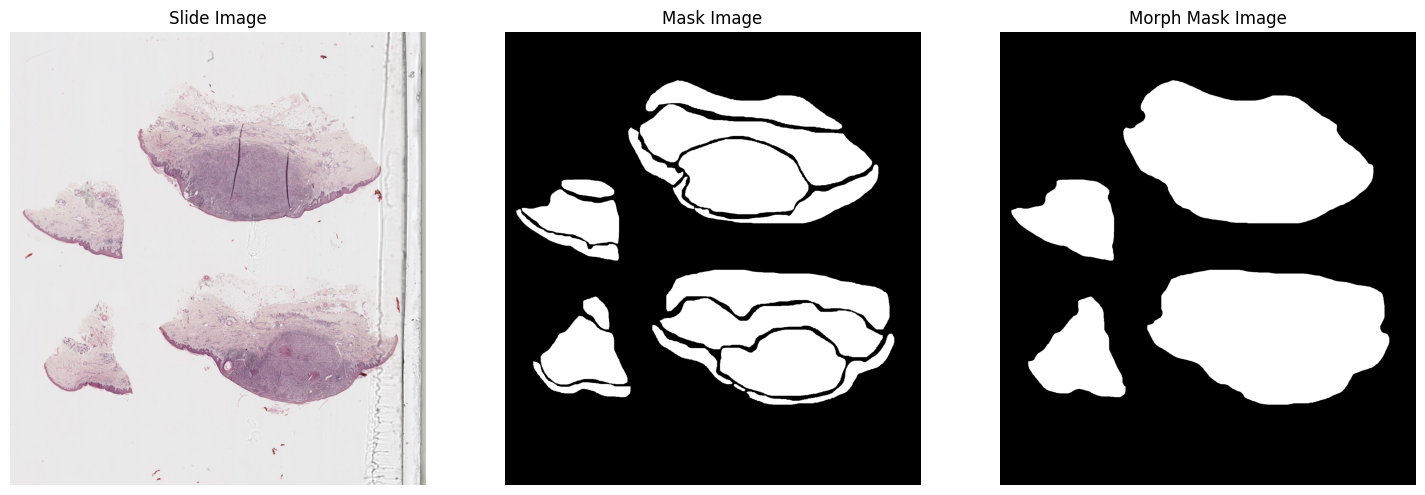

In [12]:
# Display slide
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Slide Image')
plt.imshow(image_array)
plt.axis('off')

# Display original mask
plt.subplot(1, 3, 2)
plt.title('Mask Image')
plt.imshow(filled_mask, cmap='gray')
plt.axis('off')

# Display Morphology result mask
plt.subplot(1, 3, 3)
plt.title('Morph Mask Image')
plt.imshow(closed_image.astype(np.uint8) * 255, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


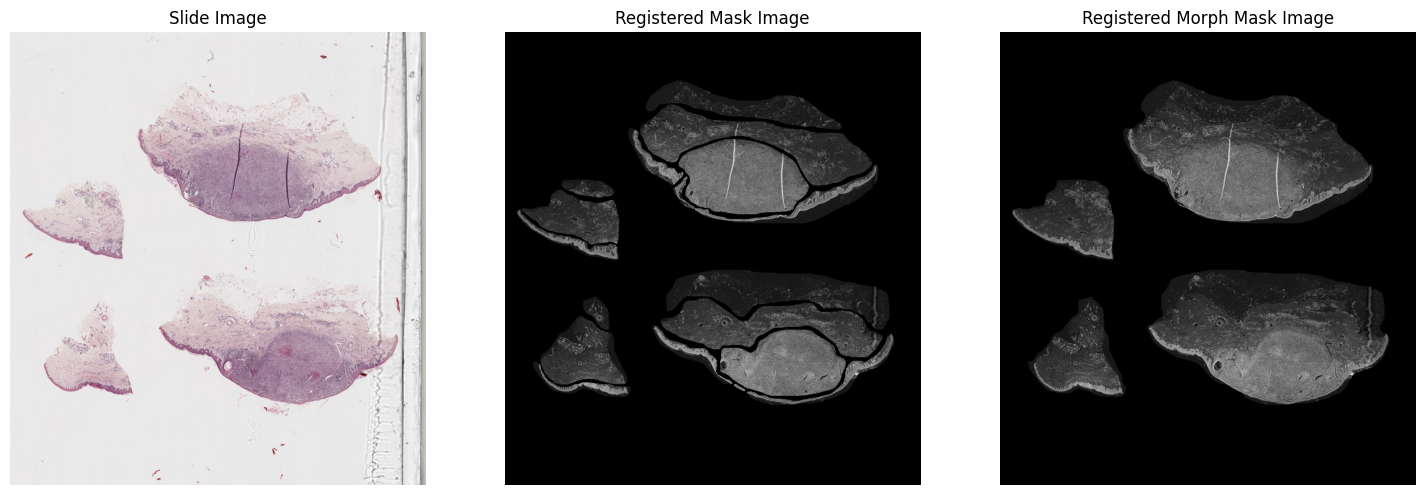

In [13]:
result_2 = closed_image * color.rgb2gray(image_array)
result2_image_uint8 = result_2.astype(np.uint8) * 255

plt.figure(figsize=(15, 5))

# Display slide
plt.subplot(1, 3, 1)
plt.title('Slide Image')
plt.imshow(image_array)
plt.axis('off')

# Display registered original mask (result_image_uint8)
plt.subplot(1, 3, 2)
plt.title('Registered Mask Image')
plt.imshow(result_image_uint8, cmap='gray')
plt.axis('off')

# Display registered morph mask (result2_image_uint8)
plt.subplot(1, 3, 3)
plt.title('Registered Morph Mask Image')
plt.imshow(result2_image_uint8, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
# Saving results and mask to have them in directory

filled_mask_float32_array = filled_mask.astype('float32')/255
cv2.imwrite('OriginalMask.png', filled_mask_float32_array) # Original filled mask
cv2.imwrite('RegisteredMask.png', result_image_uint8) # Registered Original mask
closed_mask_float32_array = closed_image.astype('float32')/255
cv2.imwrite('MorphMask_1.png', closed_image) # Morph result mask
cv2.imwrite('RegisteredMorphMask.png', result2_image_uint8) # Registered Morph mask

True

> Labeling is done to select each ROI of tissue seperately if needed.

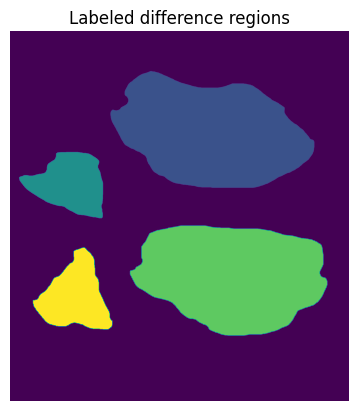

In [15]:
label_im = label(closed_image)
regions = regionprops(label_im)
plt.figure()
plt.title('Labeled difference regions')
plt.axis('off')
plt.imshow(label_im)
plt.show()


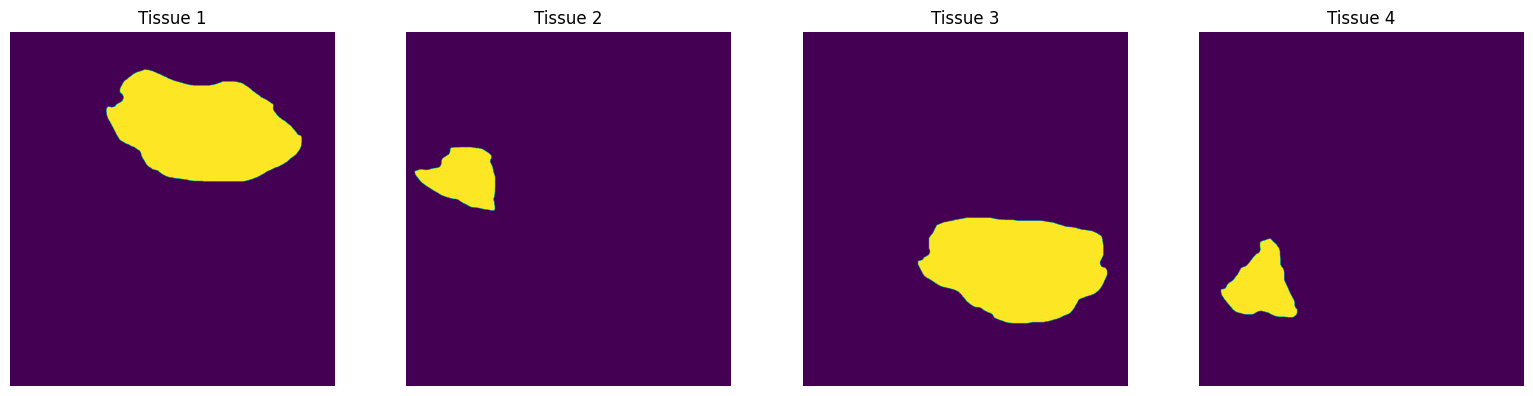

In [16]:
# 'label_im' is the labeled image
plt.figure(figsize=(16, 4))
for i, region in enumerate(regions):
    # Access the i-th region
    label_only = (label_im == region.label).astype(int)

    # Create a new subplot
    plt.subplot(1, len(regions), i+1)
    plt.title(f'Tissue {region.label}')
    plt.axis('off')

    plt.imshow(label_only)

# Adjust the layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()

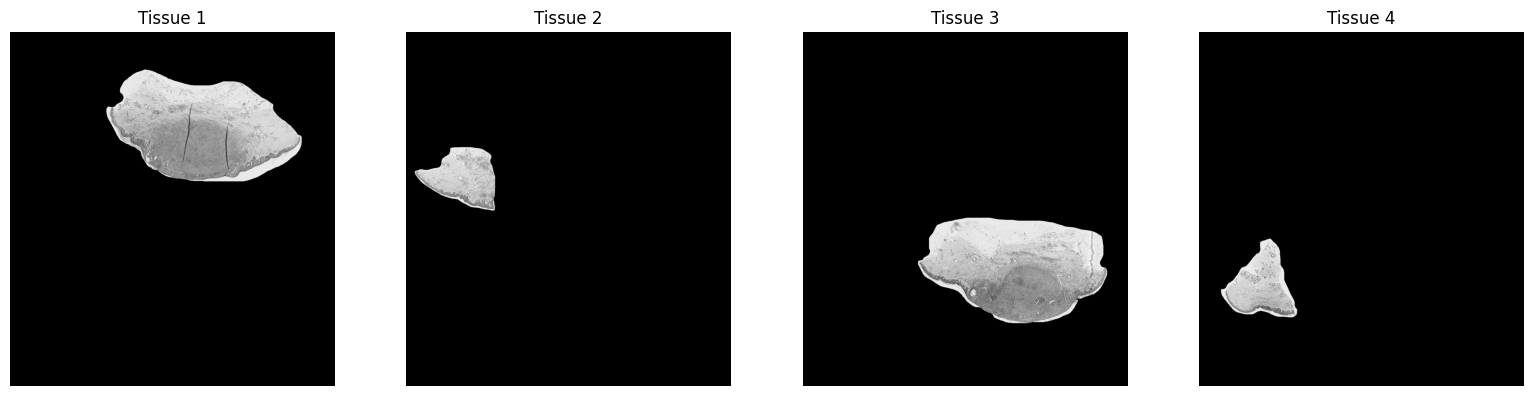

In [17]:
plt.figure(figsize=(16, 4))
for i, region in enumerate(regions):
    # Access the i-th region
    label_only = (label_im == region.label).astype(int)

    # Multiply the mask with image_array
    label_and_image = label_only * color.rgb2gray(image_array)

    # Create a new subplot
    plt.subplot(1, len(regions), i+1)
    plt.title(f'Tissue {region.label}')
    plt.axis('off')

    plt.imshow(label_and_image, cmap = 'gray')

# Adjust the layout to prevent overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()


> Applying tile action from pyvips which is desired by the task purpose

In [18]:
#Set Parameters
tile_size = 256
stride = 256
mask_path = '//content/drive/MyDrive/TestDiaDeep/MorphMask_1.png'
mask_32 = pyvips.Image.new_from_file(mask_path)

slide_width, slide_height = slide.width, slide.height



# Create Tiles with pyvips
tiles = []
masks = []
for y in range(0, slide_height - tile_size + 1, stride):
    for x in range(0, slide_width - tile_size + 1, stride):
        regionSlide = pyvips.Region.new(slide).fetch(x, y, tile_size, tile_size)
        regionMask= pyvips.Region.new(mask_32).fetch(x, y, tile_size, tile_size)
        tile = np.array(regionSlide)
        maskTile = np.array(regionMask)
        tiles.append(tile)
        # masks.append(np.squeeze(maskTile))
        # masks.append(maskTile)
        masks.append(np.expand_dims(maskTile, axis=-1))

tiles=np.stack(tiles)
masks=np.stack(masks)



x_train, x_test, y_train, y_test = train_test_split(tiles, masks, test_size = 0.2, random_state = 42)

num_samples_train = x_train.shape[0]  # Get the number of samples
num_samples_test = x_test.shape[0]
height_r = 256
width_r = 256
channels_r = 3

# Reshape to 4D array
x_train_4d = x_train.reshape(num_samples_train, height_r, width_r, channels_r)
x_test_4d = x_test.reshape(num_samples_test, height_r, width_r, channels_r)
y_train_4d = y_train.reshape(num_samples_train, height_r, width_r, 1)
y_test_4d = y_test.reshape(num_samples_test, height_r, width_r, 1)

print(len(tiles))
print(len(masks))

90
90


> The following plot shows 12 random tiles from original image

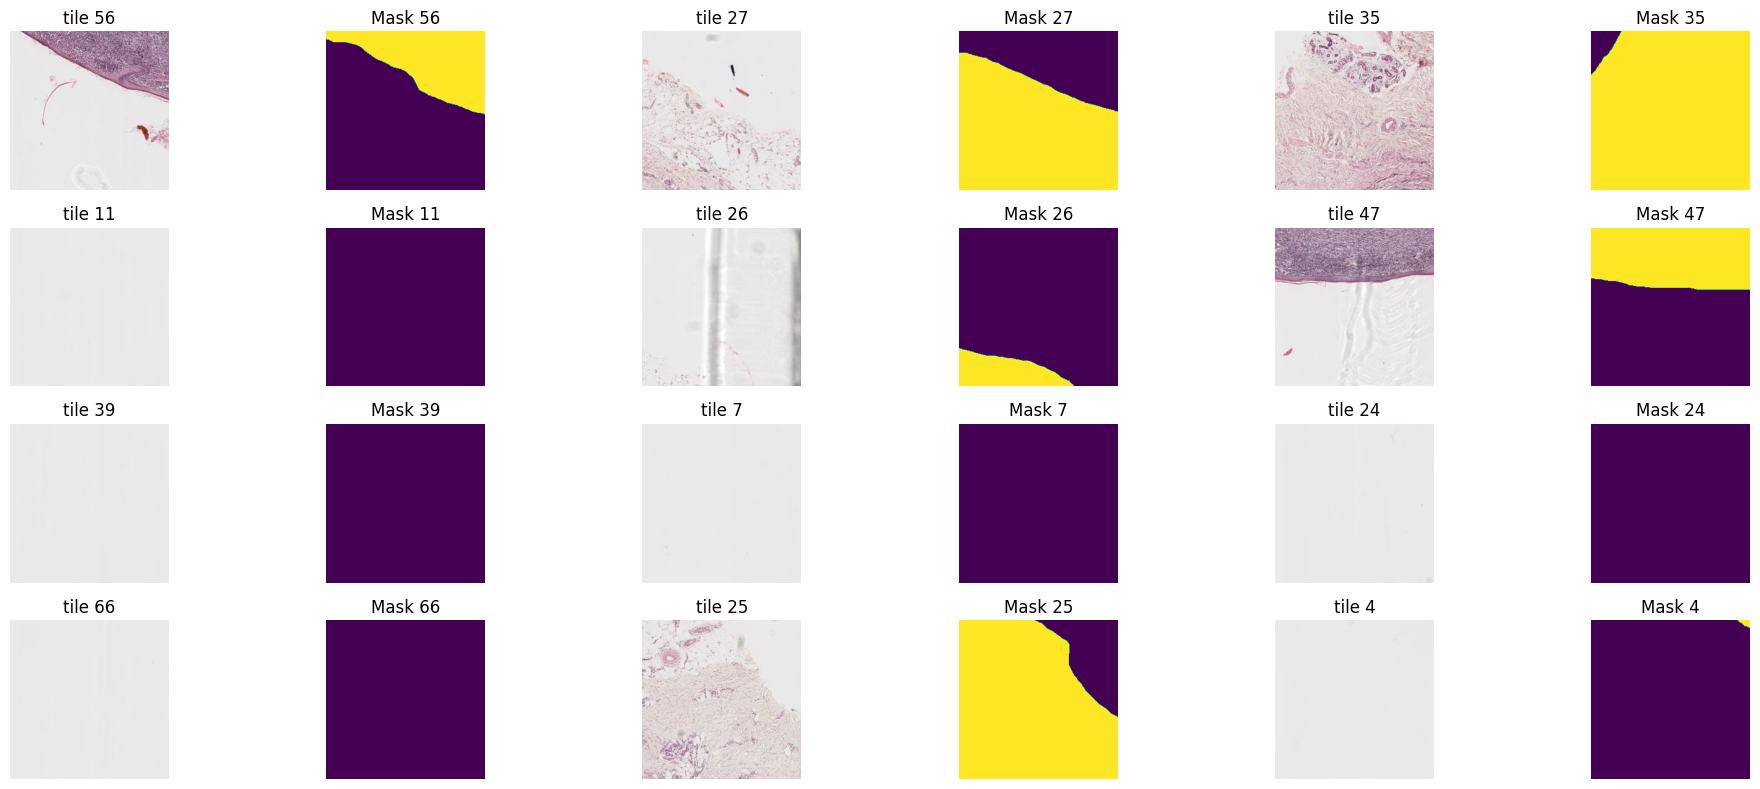

In [19]:
# Select 12 random indices
random_indices = random.sample(range(len(x_train_4d)), 12)

fig, axes = plt.subplots(4, 6, figsize=(20, 8))  # Changed to 4 rows and 6 columns

for i, idx in enumerate(random_indices):
    image = x_train_4d[idx]
    mask_ = y_train_4d[idx]

    row = i // 3
    col = i % 3 * 2

    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(f'tile {idx}')

    axes[row, col+1].imshow(np.squeeze(mask_))
    axes[row, col+1].axis('off')
    axes[row, col+1].set_title(f'Mask {idx}')

plt.tight_layout()
plt.show()


>In the following we are going to have a train directory and validation(here testset) directory and organized them for applying smp for segmentation.
- Data augmentation with different methods could be done here by comment uncomment related scripts both in definition  augmentation and in the loops of distributing images and masks



In [20]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# augmentations = [HorizontalFlip(p=1), ElasticTransform(p=1), GridDistortion(p=1), OpticalDistortion(p=1), CoarseDropout(p=1)]
# augmentations = [HorizontalFlip(p=1)]


create_dir("new_data_Morph_256_1/train/image")
create_dir("new_data_Morph_256_1/train/mask")
create_dir("new_data_Morph_256_1/test/image")
create_dir("new_data_Morph_256_1/test/mask")
save_path=r"/content/drive/MyDrive/TestDiaDeep/new_data_Morph_256_1/train"
image_path = os.path.join(save_path, "image/")
mask_path = os.path.join(save_path, "mask/")


for i in range(len(x_train)):
    try:
        image = x_train_4d[i,:,:,:]
        mask = y_train_4d[i,:,:,:]
        image_file = str(i) + ".jpg"
        mask_file = str(i) + ".jpg"
        cv2.imwrite(image_path + image_file, image)
        cv2.imwrite(mask_path + mask_file, mask)
        # print(str(i) + "Dng")

        # # for j, augmentation in enumerate(augmentations):
        # #     augmented_image = augmentation(image=image, mask=mask)["image"]
        # #     augmented_mask = augmentation(image=image, mask=mask)["mask"]
        # #     augmented_image_file = str(i) + "_" + str(j) + ".png"
        # #     augmented_mask_file = str(i) + "_" + str(j) + ".png"
        # #     cv2.imwrite(image_path + augmented_image_file, augmented_image)
        # #     cv2.imwrite(mask_path + augmented_mask_file, augmented_mask)
        # #     print(str(i) + "Pong")

    except Exception as e:
        print(f"Error occurred: {e}")


save_path="/content/drive/MyDrive/TestDiaDeep/new_data_Morph_256_1/test"
image_path = os.path.join(save_path, "image/")
mask_path = os.path.join(save_path, "mask/")

for i in range(len(x_test)):
    cv2.imwrite(image_path + str(i) + ".jpg", x_test_4d[i,:,:,:])
    cv2.imwrite(mask_path + str(i) + ".jpg", y_test_4d[i,:,:,:])
    try:
        image = x_test_4d[i,:,:,:]
        mask = y_test_4d[i,:,:,:]
        image_file = str(i) + ".jpg"
        mask_file = str(i) + ".jpg"
        cv2.imwrite(image_path + image_file, image)
        cv2.imwrite(mask_path + mask_file, mask)
        # print(str(i) + "Dng")

        # # for j, augmentation in enumerate(augmentations):
        # #     augmented_image = augmentation(image=image, mask=mask)["image"]
        # #     augmented_mask = augmentation(image=image, mask=mask)["mask"]
        # #     augmented_image_file = str(i) + "_" + str(j) + ".png"
        # #     augmented_mask_file = str(i) + "_" + str(j) + ".png"
        # #     # cv2.imwrite(image_path + augmented_image_file, augmented_image)
        # #     # cv2.imwrite(mask_path + augmented_mask_file, augmented_mask)
        # #     print(str(i) + "Dong")

    except Exception as e:
        print(f"Error occurred: {e}")


In [21]:
import os

# Specify the directory path
directory_path = '/content/drive/MyDrive/TestDiaDeep/new_data_Morph_256_1/train/image'

# Get the list of files in the directory
files = os.listdir(directory_path)

# Count the number of files
num_files = len(files)

print(f'Total number of tile images in the train directory: {num_files}')


Total number of tile images in the train directory: 72
